In [1]:
import xml.etree.ElementTree as ET


def extractPacketFeatures(filename):
    root = ET.parse(filename).getroot()

    result = []
    for packet in root.findall('packet'):
        values = {}
        for protocol in packet.findall('proto'):

            if protocol.attrib['name'] == "geninfo":
                values['packet.size'] = int(protocol.attrib['size'])

                for geninfo in protocol.findall('field'):
                    
                    if geninfo.attrib['name'] == "timestamp":
                        values['packet.timestamp'] = float(geninfo.attrib['value'])
                        
                    if geninfo.attrib['name'] == "num":
                        values['num'] = int(geninfo.attrib['show'])

            if protocol.attrib['name'] == "eth":
                values['eth.size'] = int(protocol.attrib['size'])

            if protocol.attrib['name'] == "ip":
                values['ip.size'] = int(protocol.attrib['size'])

            if protocol.attrib['name'] == "tcp":
                values['tcp.size'] = int(protocol.attrib['size'])

                for field in protocol.findall('field'):
                    if field.attrib['name'] == "tcp.flags":
                        
                        for tcpflags in field.findall('field'):                        
                            if tcpflags.attrib['name'] == "tcp.flags.ns":
                                values['tcp.flags.res'] = int(tcpflags.attrib['value']) if 'value' in tcpflags.attrib.keys() else 0
                            if tcpflags.attrib['name'] == "tcp.flags.cwr":
                                values['tcp.flags.cwr'] = int(tcpflags.attrib['value']) if 'value' in tcpflags.attrib.keys() else 0
                            if tcpflags.attrib['name'] == "tcp.flags.ecn":
                                values['tcp.flags.ecn'] = int(tcpflags.attrib['value']) if 'value' in tcpflags.attrib.keys() else 0
                            if tcpflags.attrib['name'] == "tcp.flags.urg":
                                values['tcp.flags.urg'] = int(tcpflags.attrib['value']) if 'value' in tcpflags.attrib.keys() else 0
                            if tcpflags.attrib['name'] == "tcp.flags.ack":
                                values['tcp.flags.ack'] = int(tcpflags.attrib['value']) if 'value' in tcpflags.attrib.keys() else 0
                            if tcpflags.attrib['name'] == "tcp.flags.push":
                                values['tcp.flags.push'] = int(tcpflags.attrib['value']) if 'value' in tcpflags.attrib.keys() else 0
                            if tcpflags.attrib['name'] == "tcp.flags.reset":
                                values['tcp.flags.reset'] = int(tcpflags.attrib['value']) if 'value' in tcpflags.attrib.keys() else 0
                            if tcpflags.attrib['name'] == "tcp.flags.syn":
                                values['tcp.flags.syn'] = int(tcpflags.attrib['value']) if 'value' in tcpflags.attrib.keys() else 0
                            if tcpflags.attrib['name'] == "tcp.flags.fin":
                                values['tcp.flags.fin'] = int(tcpflags.attrib['value']) if 'value' in tcpflags.attrib.keys() else 0

        values['payload.size'] = int(values['packet.size'] - values['eth.size'] - values['ip.size'] - values['tcp.size'])
        result.append(values)
        
    return result

Extract from packet following features for exploration:
- tcp flags
- tcp.flags.res
- tcp.flags.ns
- tcp.flags.cwr
- tcp.flags.ecn
- tcp.flags.urg
- tcp.flags.ack
- tcp.flags.push
- tcp.flags.reset
- tcp.flags.syn
- tcp.flags.fin
- tcp header size
- ip header size
- eth header size
- payload size
- packet size
- packet timestamp

In [6]:
dohFlows = []
for num in range(0, 30):
    dohFlows.append(extractPacketFeatures("../pcaps/doh/dohipv4-"+str(num)+".xml"))
    
dotFlows = []
for num in range(0, 30):
    dotFlows.append(extractPacketFeatures("../pcaps/dot/dotipv4-"+str(num)+".xml"))

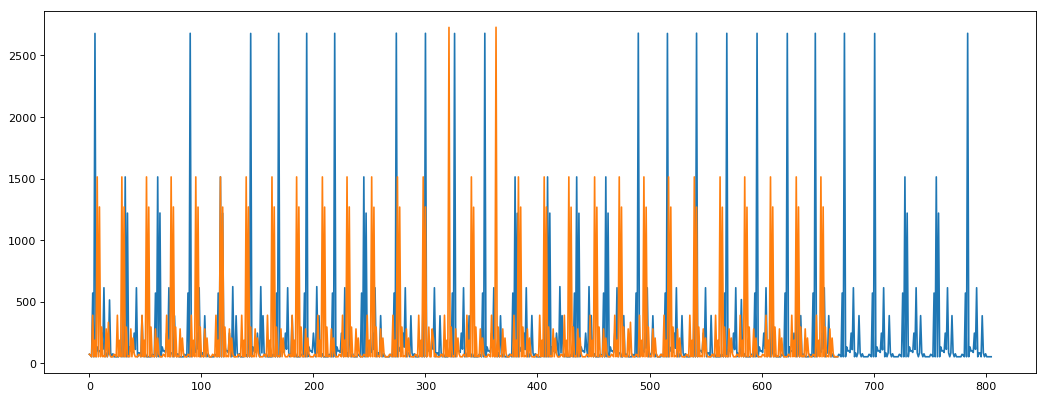

In [7]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

l = []
for i in dohFlows:
    for j in i:
        l.append(j['packet.size'])

l2 = []
for i in dotFlows:
    for j in i:
        l2.append(j['packet.size'])


plt.plot(l)
plt.plot(l2)
plt.show()

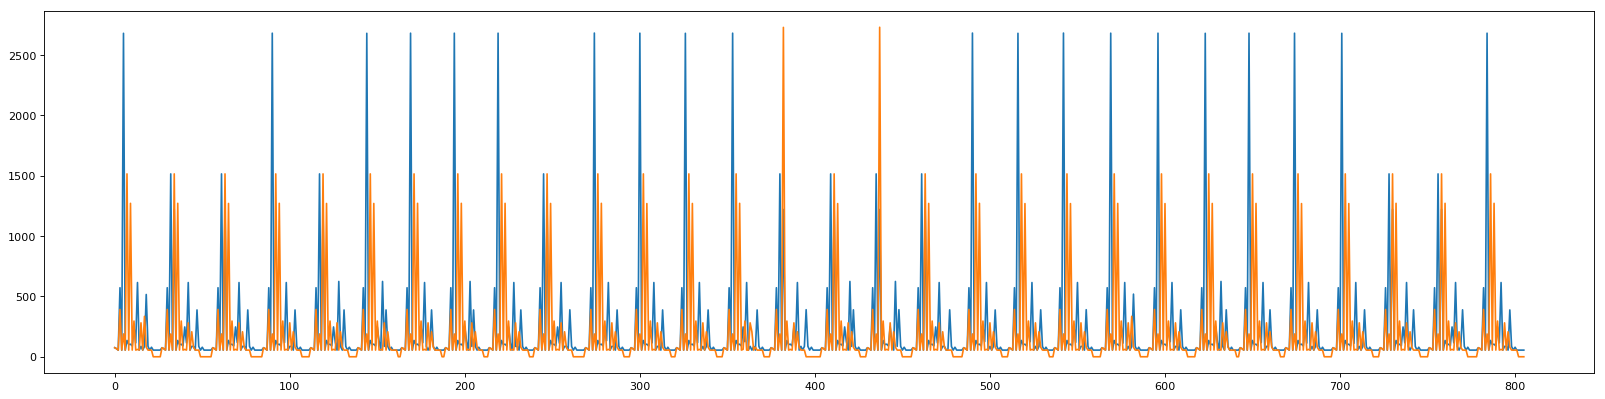

In [8]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')

l = []
l2 = []

for i in range(0, len(dohFlows)):
    for j in range(0, len(dohFlows[i])):
        if j < len(dotFlows[i]):
            l2.append(dotFlows[i][j]['packet.size'])
        else:
            l2.append(-1)
        l.append(dohFlows[i][j]['packet.size'])


plt.plot(l)
plt.plot(l2)
plt.show()

Extract from flow following features:
- packet size max, min, std, mean, sum
- tcpflag push count
- payload 0 count
- payload size max, min, std, mean, sum
- packets count

In [9]:
import pandas as pd
import numpy as np

def getFlowFeatures(flowPackets):
    flow = {}
    dfPackets = pd.DataFrame(flowPackets)
    payloadSize = dfPackets['payload.size'].describe(include="all")
    packetSize = dfPackets['packet.size'].describe(include="all")
    
    flow['packet.min'] = packetSize['min']
    flow['packet.max'] = packetSize['max']
    flow['packet.std'] = packetSize['std']
    flow['packet.mean'] = packetSize['mean']
    flow['packet.sum'] = dfPackets['packet.size'].sum()
    
    flow['payload.min'] = payloadSize['min']
    flow['payload.max'] = payloadSize['max']
    flow['payload.std'] = payloadSize['std']
    flow['payload.mean'] = payloadSize['mean']
    flow['payload.sum'] = dfPackets['payload.size'].sum()
    
    flow['payload.0count'] = dfPackets['payload.size'].value_counts()[0]
    flow['packet.count'] = len(flowPackets)
    flow['tcp.flags.pushcount'] = dfPackets['tcp.flags.push'].sum()
    
    return flow
    
dohStat = getFlowFeatures(dohFlows[0])
dotStat = getFlowFeatures(dotFlows[0])

print(dohStat)
print(dotStat)
    
    

{'packet.min': 54.0, 'packet.max': 2679.0, 'packet.std': 515.0253942235826, 'packet.mean': 230.8148148148148, 'packet.sum': 6232, 'payload.min': 0.0, 'payload.max': 2625.0, 'payload.std': 515.4260484259711, 'payload.mean': 175.62962962962962, 'payload.sum': 4742, 'payload.0count': 13, 'packet.count': 27, 'tcp.flags.pushcount': 14}
{'packet.min': 54.0, 'packet.max': 1514.0, 'packet.std': 391.5253000842482, 'packet.mean': 233.8181818181818, 'packet.sum': 5144, 'payload.min': 0.0, 'payload.max': 1460.0, 'payload.std': 392.18867488742796, 'payload.mean': 178.36363636363637, 'payload.sum': 3924, 'payload.0count': 13, 'packet.count': 22, 'tcp.flags.pushcount': 8}


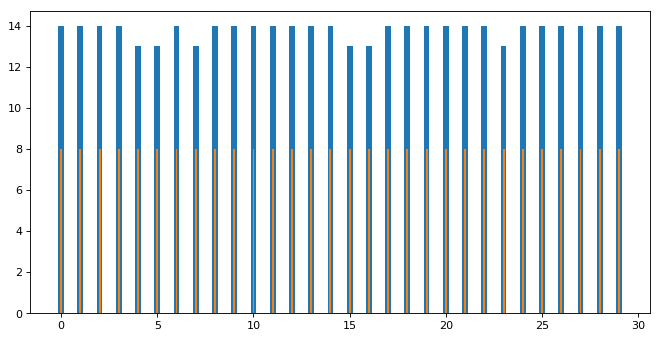

In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np

figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')


dohFlowsStats = pd.DataFrame([getFlowFeatures(flow) for flow in dohFlows])
dotFlowsStats = pd.DataFrame([getFlowFeatures(flow) for flow in dotFlows])


ax = plt.subplot(111)
ax.bar(np.arange(len(dohFlowsStats)), dohFlowsStats['tcp.flags.pushcount'], 0.3)
ax.bar(np.arange(len(dotFlowsStats)), dotFlowsStats['tcp.flags.pushcount'], 0.1)
plt.show()